If you are just a student and dont have enough computation power and/or training set  
Just use a pre-trained model as we do  
Using pre-trained model from there: https://github.com/endernewton/tf-faster-rcnn  
Patching for using just CPU: https://github.com/endernewton/tf-faster-rcnn/issues/72  

In [1]:
import os 
import sys

this_dir = os.getcwd()
print(this_dir)

# Add lib to PYTHONPATH
lib_path = os.path.join(this_dir, 'tf-faster-rcnn', 'lib')
sys.path.insert(0, lib_path)
print(lib_path)

coco_path = os.path.join(this_dir, 'tf-faster-rcnn', 'data', 'coco', 'PythonAPI')
sys.path.insert(0, coco_path)

/home/jovyan/work/NetsLab
/home/jovyan/work/NetsLab/tf-faster-rcnn/lib


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from model.config import cfg
from model.test import im_detect
from model.nms_wrapper import nms

from utils.timer import Timer
import tensorflow as tf
import matplotlib.pyplot as plt
print(tf.__version__)
import numpy as np
import os, cv2
import argparse

from nets.vgg16 import vgg16
from nets.resnet_v1 import resnetv1

1.3.0


In [3]:
% matplotlib inline

In [4]:
anchor_scales = [2, 4, 8, 16, 32] 
CLASSES = ('background',
'person', 'bicycle', 'car', 'motorcycle', 'airplane',
'bus','train', 'truck', 'boat', 'traffic light', 'fire hydrant',
'stop sign', 'parking meter','bench', 'bird', 'cat', 'dog',
'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe',
'backpack','umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
'skis', 'snowboard', 'sports ball', 'kite','baseball bat', 'baseball glove',
'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
'fork', 'knife', 'spoon', 'bowl','banana', 'apple', 'sandwich', 'orange',
'broccoli','carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
'potted plant', 'bed', 'dining table','toilet', 'tv', 'laptop', 'mouse', 'remote',
'keyboard', 'cell phone', 'microwave', 'oven','toaster', 'sink', 'refrigerator',
'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush')


In [5]:
def vis_detections(class_name, dets, ax, thresh=0.5):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if len(inds) == 0:
        return

    
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]

        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
            )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')


    #plt.draw()
    #plt.savefig(save_path)
    #plt.show()

In [6]:
def demo(sess, net, image_name):
    """Detect object classes in an image using pre-computed object proposals."""

    # Load the demo image
    im_file = os.path.join(this_dir, "data/images", image_name)
    im_save_file = os.path.join(this_dir, "data/images_out/fasterrcnn_vgg", image_name)
    im = cv2.imread(im_file)

    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    scores, boxes = im_detect(sess, net, im)
    timer.toc()
    print('Detection took {:.3f}s for {:d} object proposals'.format(timer.total_time, boxes.shape[0]))

    # Visualize detections for each class
    CONF_THRESH = 0.8
    NMS_THRESH = 0.3
    
    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1 # because we skipped background
        cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        vis_detections(cls, dets, ax, thresh=CONF_THRESH)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(im_save_file)
    plt.show()

INFO:tensorflow:Restoring parameters from /home/jovyan/work/NetsLab/data/Faster-RCNN/vgg16_faster_rcnn_iter_1190000.ckpt
Loaded network /home/jovyan/work/NetsLab/data/Faster-RCNN/vgg16_faster_rcnn_iter_1190000.ckpt
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo/000456.jpg
Detection took 10.660s for 300 object proposals


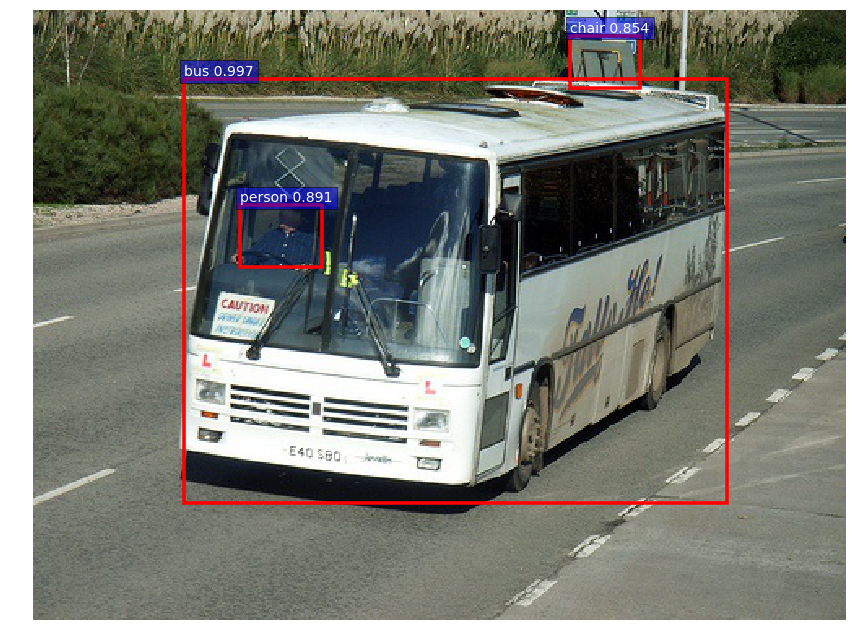

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo/000542.jpg
Detection took 9.136s for 103 object proposals


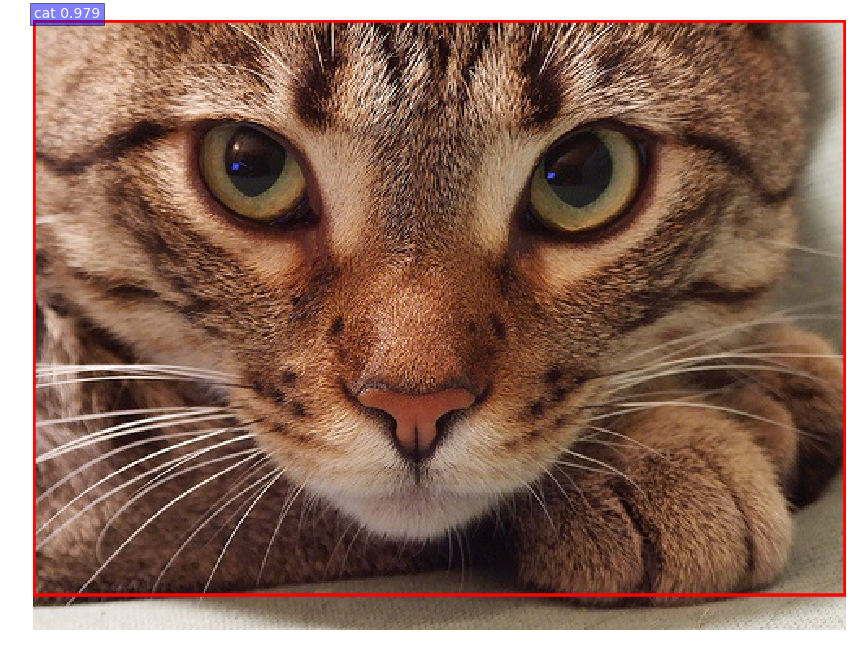

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo/001150.jpg
Detection took 9.962s for 173 object proposals


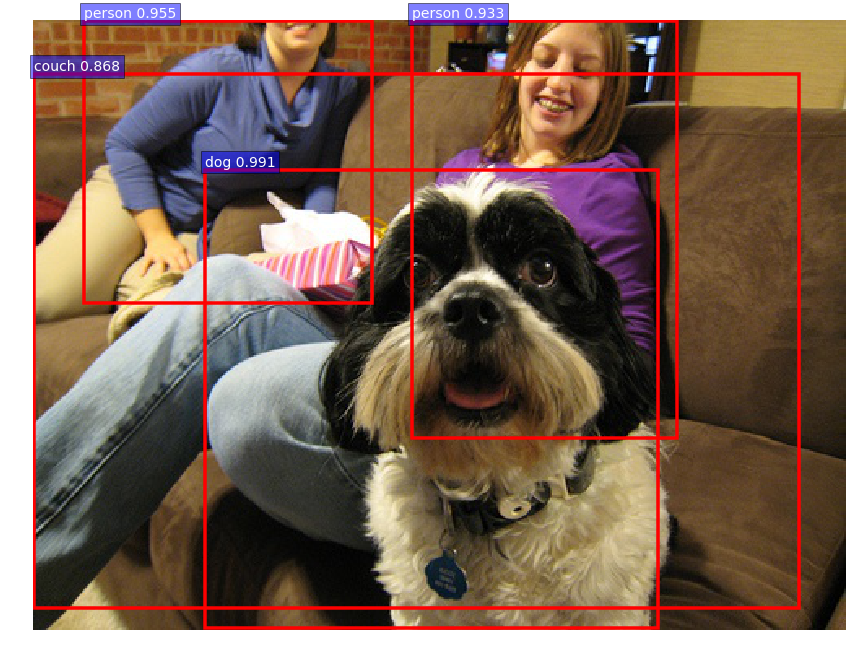

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo/001763.jpg
Detection took 9.218s for 184 object proposals


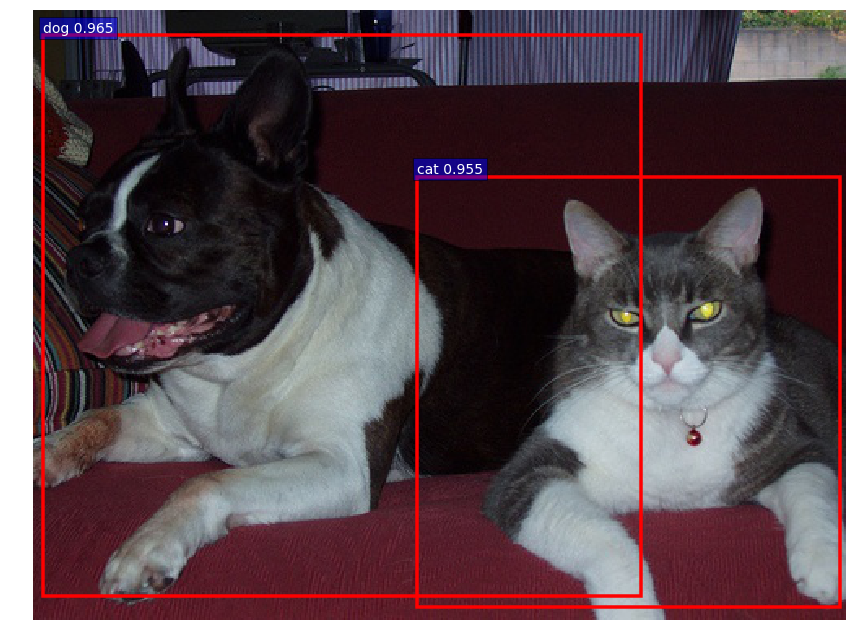

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo/004545.jpg
Detection took 9.858s for 300 object proposals


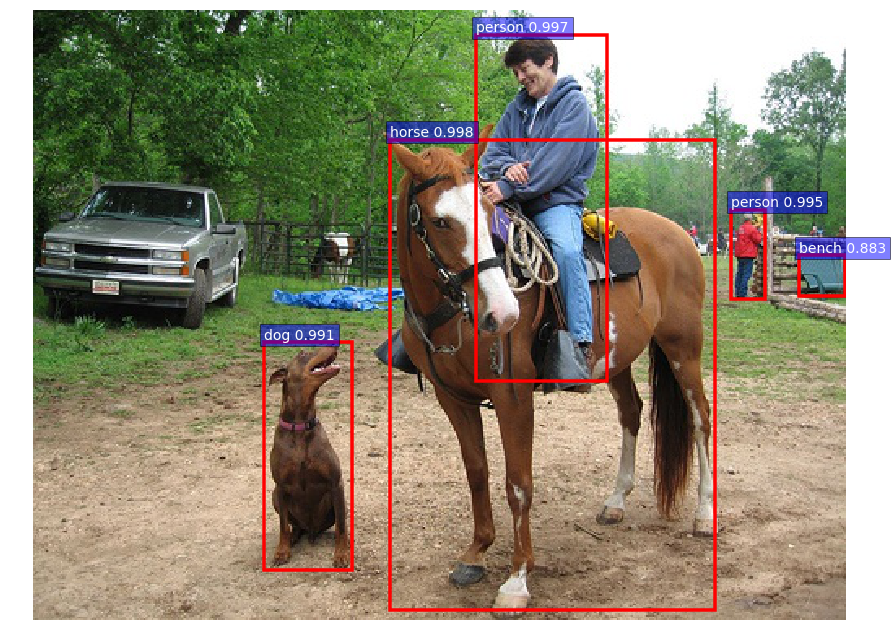

100%|██████████| 100/100 [10:16<00:00,  6.17s/it]

[8.655227661132812, 9.132044553756714, 8.966456651687622, 8.81244969367981, 8.759700059890747, 8.905620574951172, 8.494788408279419, 8.77250051498413, 8.87157678604126, 9.267009496688843, 8.941847085952759, 8.839092493057251, 8.718064308166504, 7.084672927856445, 5.646327018737793, 5.663186311721802, 5.607642889022827, 5.656944036483765, 5.760708570480347, 5.610386848449707, 5.638723611831665, 5.568955898284912, 5.758932590484619, 5.714379549026489, 5.734114170074463, 5.757102727890015, 5.8274736404418945, 5.861988544464111, 5.767575263977051, 5.592681407928467, 5.567440748214722, 5.7417991161346436, 5.778332233428955, 6.165766000747681, 7.118005990982056, 7.2772064208984375, 6.532325506210327, 5.889716863632202, 5.669131755828857, 5.62802267074585, 5.712945461273193, 5.729369640350342, 5.741736173629761, 5.818144083023071, 5.723182201385498, 5.634241342544556, 5.580626487731934, 5.701149225234985, 5.705499887466431, 5.646992444992065, 5.534327268600464, 5.703623056411743, 5.6026182174

In [7]:
cfg.TEST.HAS_RPN = True  # Use RPN for proposals

# model path
tfmodel = os.path.join(this_dir, "data", "Faster-RCNN/vgg16_faster_rcnn_iter_1190000.ckpt")


if not os.path.isfile(tfmodel + '.meta'):
    raise IOError(('{:s} not found.\nDid you download the proper networks from '
                   'our server and place them properly?').format(tfmodel + '.meta'))

# init session
sess = tf.Session()
# load network
net = vgg16()
net.create_architecture("TEST", len(CLASSES), tag='default', anchor_scales=[4, 8, 16, 32])
saver = tf.train.Saver()
saver.restore(sess, tfmodel)

print('Loaded network {:s}'.format(tfmodel))

im_names = ['000456.jpg', '000542.jpg', '001150.jpg',
            '001763.jpg', '004545.jpg']
for im_name in im_names:
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('Demo for data/demo/{}'.format(im_name))
    demo(sess, net, im_name)
plt.show()

# Performance measurements block
import time
from tqdm import tqdm
perf_image = this_dir + "/data/images/" + "000542.jpg"
times = list()
im = cv2.imread(perf_image)
for i in tqdm(range(100)):
    timestart = time.time()
    im_detect(sess, net, im)
    times.append(time.time() - timestart)
print(times)    
performance = np.array(times)
print("Mean:", np.mean(performance))
print("Median:", np.median(performance))
print("Q25:", np.percentile(performance, 25))
print("Q75:", np.percentile(performance, 75))
##############################################################

sess.close()

In [8]:
path = this_dir + '/data/images/test_data'
image_names = sorted(os.listdir(path))

FileNotFoundError: [Errno 2] No such file or directory: '/home/jovyan/work/NetsLab/data/images/test_data'